#  Group 24 : Phase 0 - Cats vs Dogs Detector (CaDoD) 

##   Team Members 
    Atharva Kulkarni
    Chinmay Kunte
    Sanket Darwante
    David Rivera Pinhao

## Project Abstract

Computer vision is a field of study that deals with how computers can gain the ability to “see”. One of the biggest challenges is object detection. In this phase, we will explore the Cats and Dogs dataset and build a baseline model that will be able to classify the images. We used Logistic Regression as our classifier which was optimized using stochastic gradient descent and an adaptive learning rate. Finally, we used Linear Regression to predict bounding boxes and again used gradient descent. This was implemented using SKLearn’s build in models SGDClassifier and LinearRegression. From about 12k images we achieved a test accuracy of 0.554 with a mean squared error of 0.035 for classifying images and predicting the bounding boxes, respectively. Overall, this proved to be a good baseline and benchmark. We plan to take this further in our next experiments to improve both metrics using Deep Learning.

## Project Description

The purpose of this project is create an end to end pipeline in machine learning to create an object detector for cats and dogs. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, take their RGB intensity values and flatten them from a 3D array to 2D. Then we will feed this array into a linear classifier and a linear regressor to predict labels and bounding boxes.

## Data Description
#TODO add preprocessing steps before this notebook

The image archive cadod.tar.gz is a subset Open Images V6. It contains a total of 12,966 images of dogs and cats.

Image bounding boxes are stored in the csv file cadod.csv. The following describes whats contained inside the csv.

ImageID: the image this box lives in.
Source: indicates how the box was made:
xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
LabelName: the MID of the object class this box belongs to.
Confidence: a dummy value, always 1.
XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.
The attributes have the following definitions:

IsOccluded: Indicates that the object is occluded by another object in the image.
IsTruncated: Indicates that the object extends beyond the boundary of the image.
IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building). For each of them, value 1 indicates present, 0 not present, and -1 unknown.

# Import Data

In [3]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tarfile
from tqdm.notebook import tqdm
import warnings

## Unarchive Data

In [2]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [3]:
path = 'data1/'
extract_tar('cadod.tar.gz', path)

  0%|          | 0/25936 [00:00<?, ?it/s]

## Load bounding box meta data 

In [4]:
df = pd.read_csv('cadod.csv')

In [5]:
df.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

# Exploratory Data Analysis

## Statistics

In [6]:
df.shape

(12966, 21)

In [7]:
df.isnull().count()

ImageID        12966
Source         12966
LabelName      12966
Confidence     12966
XMin           12966
XMax           12966
YMin           12966
YMax           12966
IsOccluded     12966
IsTruncated    12966
IsGroupOf      12966
IsDepiction    12966
IsInside       12966
XClick1X       12966
XClick2X       12966
XClick3X       12966
XClick4X       12966
XClick1Y       12966
XClick2Y       12966
XClick3Y       12966
XClick4Y       12966
dtype: int64

In [8]:
df.describe()

Confidence          XMin          XMax          YMin          YMax  \
count     12966.0  12966.000000  12966.000000  12966.000000  12966.000000   
mean          1.0      0.099437      0.901750      0.088877      0.945022   
std           0.0      0.113023      0.111468      0.097345      0.081500   
min           1.0      0.000000      0.408125      0.000000      0.451389   
25%           1.0      0.000000      0.830625      0.000000      0.910000   
50%           1.0      0.061250      0.941682      0.059695      0.996875   
75%           1.0      0.167500      0.998889      0.144853      0.999062   
max           1.0      0.592500      1.000000      0.587088      1.000000   

         IsOccluded   IsTruncated     IsGroupOf   IsDepiction      IsInside  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.464754      0.738470      0.013651      0.045427      0.001157   
std        0.499239      0.440011      0.118019      0.209354      0.040229   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           XClick1X      XClick2X      XClick3X      XClick4X      XClick1Y  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.390356      0.424582      0.494143      0.506689      0.275434   
std        0.358313      0.441751      0.405033      0.462281      0.415511   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.221293      0.096875      0.285071      0.130000      0.024323   
50%        0.435625      0.415625      0.531919      0.623437      0.146319   
75%        0.609995      0.820000      0.787500      0.917529      0.561323   
max        0.999375      0.999375      1.000000      0.999375      0.999375   

           XClick2Y      XClick3Y      XClick4Y  
count  12966.000000  12966.000000  12966.000000  
mean       0.447448      0.641749      0.582910  
std        0.401580      0.448054      0.403454  
min       -1.000000     -1.000000     -1.000000  
25%        0.218333      0.405816      0.400000  
50%        0.480838      0.825000      0.646667  
75%        0.729069      0.998042      0.882500  
max        0.999375      1.000000      0.999375

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12966 entries, 0 to 12965
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      12966 non-null  object 
 1   Source       12966 non-null  object 
 2   LabelName    12966 non-null  object 
 3   Confidence   12966 non-null  int64  
 4   XMin         12966 non-null  float64
 5   XMax         12966 non-null  float64
 6   YMin         12966 non-null  float64
 7   YMax         12966 non-null  float64
 8   IsOccluded   12966 non-null  int64  
 9   IsTruncated  12966 non-null  int64  
 10  IsGroupOf    12966 non-null  int64  
 11  IsDepiction  12966 non-null  int64  
 12  IsInside     12966 non-null  int64  
 13  XClick1X     12966 non-null  float64
 14  XClick2X     12966 non-null  float64
 15  XClick3X     12966 non-null  float64
 16  XClick4X     12966 non-null  float64
 17  XClick1Y     12966 non-null  float64
 18  XClick2Y     12966 non-null  float64
 19  XCli

In [10]:
numerical_ix = df.select_dtypes(include = ['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include = ['object', 'bool']).columns
print(f'numerical   features: {list(numerical_ix)}')
print(f'categorical features: {list(categorical_ix)}')

numerical   features: ['Confidence', 'XMin', 'XMax', 'YMin', 'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside', 'XClick1X', 'XClick2X', 'XClick3X', 'XClick4X', 'XClick1Y', 'XClick2Y', 'XClick3Y', 'XClick4Y']
categorical features: ['ImageID', 'Source', 'LabelName']


In [11]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace = True)
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

In [12]:
df.corr()

Confidence      XMin      XMax      YMin      YMax  IsOccluded  \
Confidence          NaN       NaN       NaN       NaN       NaN         NaN   
XMin                NaN  1.000000  0.103804  0.090813  0.006290    0.112251   
XMax                NaN  0.103804  1.000000 -0.083529  0.001176   -0.115249   
YMin                NaN  0.090813 -0.083529  1.000000 -0.073181    0.147739   
YMax                NaN  0.006290  0.001176 -0.073181  1.000000   -0.062223   
IsOccluded          NaN  0.112251 -0.115249  0.147739 -0.062223    1.000000   
IsTruncated         NaN -0.149003  0.157319 -0.208849  0.343788   -0.093756   
IsGroupOf           NaN -0.045129  0.047915 -0.007378 -0.010383    0.089984   
IsDepiction         NaN -0.003565 -0.020573  0.015071 -0.035134   -0.032279   
IsInside            NaN -0.001281  0.001948  0.005109 -0.023480    0.026993   
XClick1X            NaN  0.171845  0.082206  0.047808 -0.006224    0.073061   
XClick2X            NaN  0.104226  0.110433  0.008927 -0.006295    0.029136   
XClick3X            NaN  0.154513  0.234758 -0.001801 -0.009941    0.042914   
XClick4X            NaN  0.184075  0.176847  0.037606  0.008905    0.100454   
XClick1Y            NaN -0.014338 -0.012135  0.135875  0.018956    0.080188   
XClick2Y            NaN  0.001371 -0.036563  0.176044  0.091570    0.091800   
XClick3Y            NaN  0.037439  0.038044  0.101187  0.145309    0.035143   
XClick4Y            NaN  0.014788  0.051177  0.098794  0.131983    0.066217   

             IsTruncated  IsGroupOf  IsDepiction  IsInside  XClick1X  \
Confidence           NaN        NaN          NaN       NaN       NaN   
XMin           -0.149003  -0.045129    -0.003565 -0.001281  0.171845   
XMax            0.157319   0.047915    -0.020573  0.001948  0.082206   
YMin           -0.208849  -0.007378     0.015071  0.005109  0.047808   
YMax            0.343788  -0.010383    -0.035134 -0.023480 -0.006224   
IsOccluded     -0.093756   0.089984    -0.032279  0.026993  0.073061   
IsTruncated     1.000000  -0.017391    -0.095418 -0.004693  0.009881   
IsGroupOf      -0.017391   1.000000     0.031091  0.045410  0.040796   
IsDepiction    -0.095418   0.031091     1.000000  0.021234  0.014577   
IsInside       -0.004693   0.045410     0.021234  1.000000  0.026219   
XClick1X        0.009881   0.040796     0.014577  0.026219  1.000000   
XClick2X        0.032514   0.025022    -0.002304  0.031492  0.515711   
XClick3X        0.057065   0.016812    -0.013640  0.016644  0.302655   
XClick4X        0.014494   0.012422     0.002735 -0.001875  0.351178   
XClick1Y        0.003144  -0.010900    -0.001785  0.024680  0.292254   
XClick2Y        0.019021   0.022449     0.011127  0.005625  0.514306   
XClick3Y        0.081859   0.032975     0.007438  0.014154  0.558042   
XClick4Y        0.090464   0.016375    -0.001444  0.005826  0.490527   

             XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
Confidence        NaN       NaN       NaN       NaN       NaN       NaN   
XMin         0.104226  0.154513  0.184075 -0.014338  0.001371  0.037439   
XMax         0.110433  0.234758  0.176847 -0.012135 -0.036563  0.038044   
YMin         0.008927 -0.001801  0.037606  0.135875  0.176044  0.101187   
YMax        -0.006295 -0.009941  0.008905  0.018956  0.091570  0.145309   
IsOccluded   0.029136  0.042914  0.100454  0.080188  0.091800  0.035143   
IsTruncated  0.032514  0.057065  0.014494  0.003144  0.019021  0.081859   
IsGroupOf    0.025022  0.016812  0.012422 -0.010900  0.022449  0.032975   
IsDepiction -0.002304 -0.013640  0.002735 -0.001785  0.011127  0.007438   
IsInside     0.031492  0.016644 -0.001875  0.024680  0.005625  0.014154   
XClick1X     0.515711  0.302655  0.351178  0.292254  0.514306  0.558042   
XClick2X     1.000000  0.349234 -0.111941  0.339360  0.379019  0.396836   
XClick3X     0.349234  1.000000  0.460921  0.443243  0.360727  0.445288   
XClick4X    -0.111941  0.460921  1.000000  0.341789  0.412812  0.397735   
XClick1Y     0.33

## Image Samples

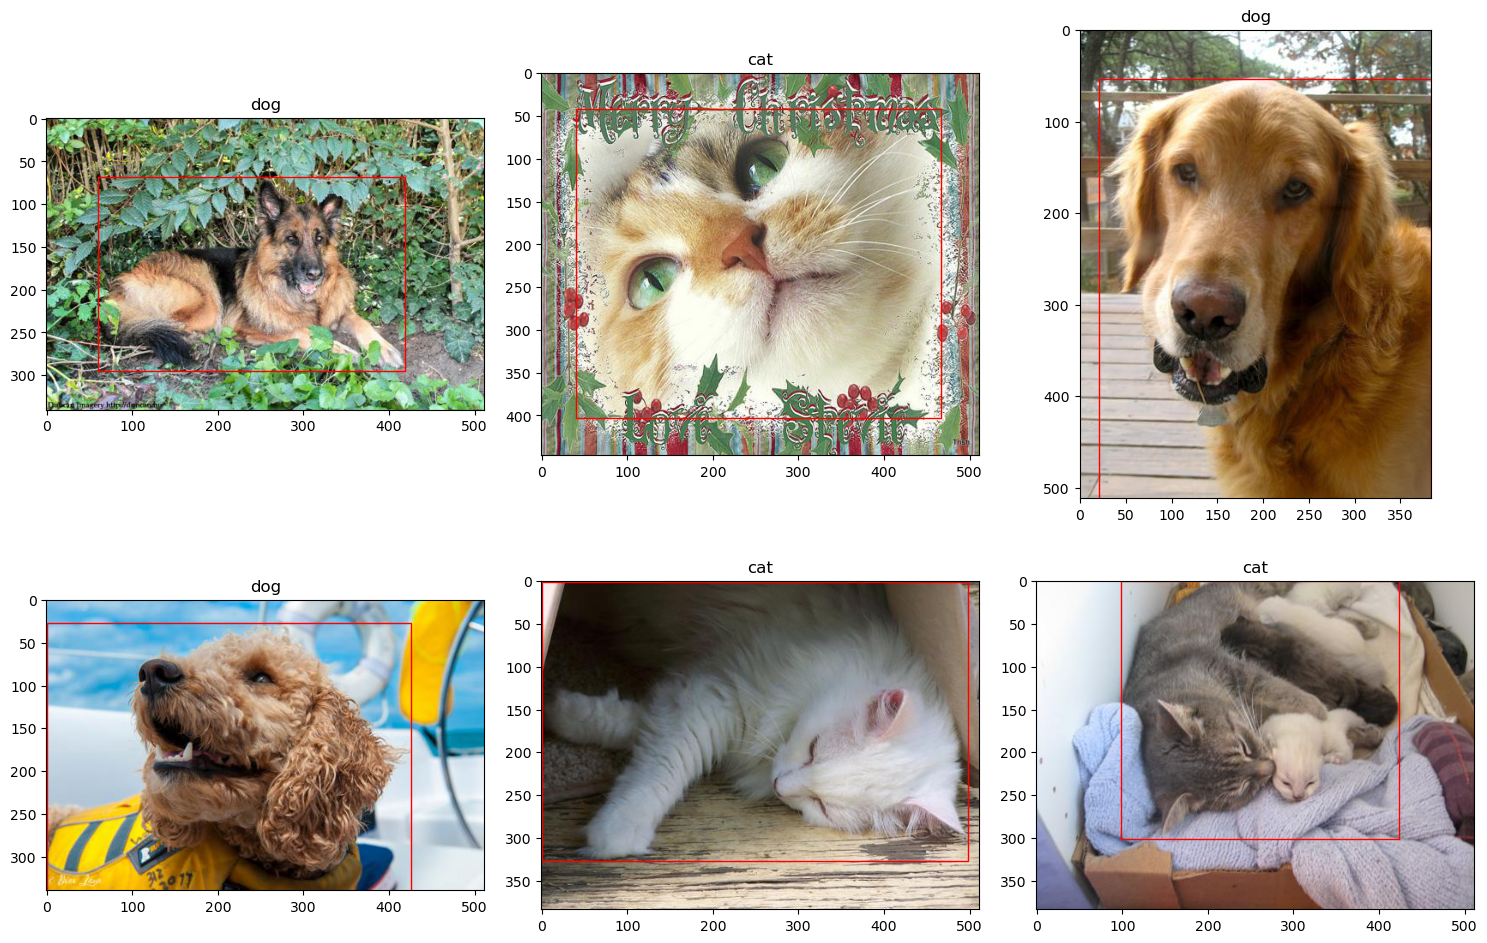

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False, figsize = (15, 10))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(df.shape[0], size = 6, replace = False)):
    img = mpimg.imread('data1/' + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j, 4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0] * w, coords[2] * h),
                                  coords[1] * w - coords[0] * w, coords[3] * h - coords[2] * h,
                                  edgecolor = 'red', facecolor = 'none'))

plt.tight_layout()
plt.show()

## Image SHapes and Sizes

In [16]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))

for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path + '/' + f
    img = Image.open(file)
    img_shape.append(f'{img.size[0]}x{img.size[1]}')
    img_size[i] += os.path.getsize(file)

  0%|          | 0/12966 [00:00<?, ?it/s]

In [17]:
# Count different sizes
img_shape_count = Counter(img_shape)

In [18]:
# Create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns = ['img_shape','img_count'])
img_df

img_shape  img_count
0     512x403         12
1     512x298          4
2     448x384          1
3     384x429          1
4     512x414          8
..        ...        ...
589   512x502          5
590   366x512          8
591   310x512          2
592   492x512          2
593   384x491          1

[594 rows x 2 columns]

In [19]:
img_df.shape

(594, 2)

In [20]:
#There are a ton of different image shapes. 
#Let's narrow this down by getting a sum of any image shape that has a cout less than 100 and 
#put that in a category called other

img_df = img_df.append({'img_shape': 'other', 'img_count': img_df[img_df.img_count < 100].img_count.sum()},
                       ignore_index=True)
img_df

img_shape  img_count
0     512x403         12
1     512x298          4
2     448x384          1
3     384x429          1
4     512x414          8
..        ...        ...
590   366x512          8
591   310x512          2
592   492x512          2
593   384x491          1
594     other       3259

[595 rows x 2 columns]

In [21]:
img_df = img_df[img_df.img_count >= 100]
img_df

img_shape  img_count
55    512x339        169
57    512x512       1103
81    341x512        331
86    384x384        113
163   512x341       2013
167   512x384       3782
181   340x512        143
224   384x512        616
260   512x288        182
341   512x382        127
421   512x340        736
512   512x342        392
594     other       3259

In [22]:
img_df.img_count.sum() == df.shape[0]

True

# Preprocessing

## Rescaling

In [23]:
!mkdir -p data1/resized

In [24]:
%%time
# Resize image and save, convert to numpy

img_arr = np.zeros((df.shape[0], 128 * 128 * 3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(path + f + '.jpg')
    img_resized = img.resize((128, 128))
    img_resized.save('data1/resized/' + f + '.jpg', 'JPEG', optimize = True)
    img_arr[i] = np.asarray(img_resized, dtype = np.uint8).flatten()

  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 10.7 s, total: 1min 39s
Wall time: 2min 54s


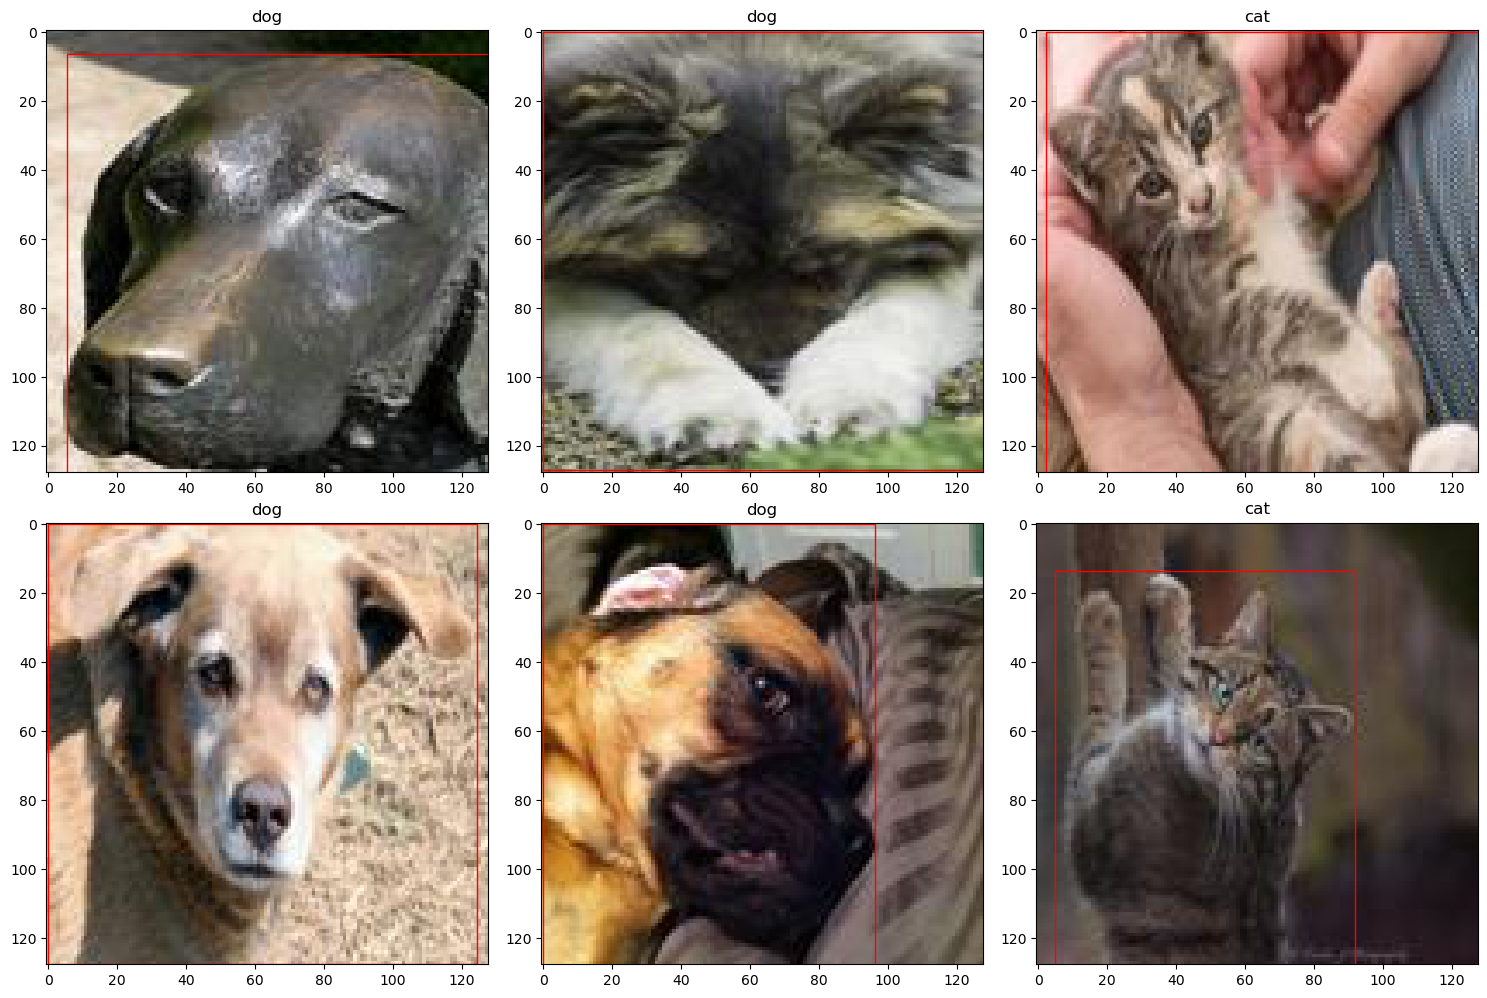

In [25]:
# Plot random 6 images
fig, ax = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False, figsize = (15, 10))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(df.shape[0], size = 6, replace = False)):
    img = mpimg.imread(path + '/resized/' + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j, 4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j, 2])
    ax[i].add_patch(plt.Rectangle((coords[0] * w, coords[2] * h), 
                                  coords[1] * w - coords[0] * w, coords[3] * h - coords[2] * h, 
                                  edgecolor = 'red', facecolor = 'none'))

plt.tight_layout()
plt.show()

In [26]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

## Checkpoint

In [27]:
mkdir -p checkpoints

In [28]:
np.save('checkpoints/img.npy', img_arr.astype(np.uint8))
np.save('checkpoints/y_label.npy', df.Label.values)
np.save('checkpoints/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

# Baseline Models

## Load the data

In [4]:
X = np.load('checkpoints/img.npy', allow_pickle = True)
y_label = np.load('checkpoints/y_label.npy', allow_pickle = True)
y_bbox = np.load('checkpoints/y_bbox.npy', allow_pickle = True)

## Check the numpy arrays and their shapes

In [5]:
print(X.shape, y_label.shape, y_bbox.shape)

(12966, 49152) (12966,) (12966, 4)


In [6]:
X

array([[ 55, 129, 179, ...,  59, 140, 203],
       [121, 121, 119, ..., 254, 255, 255],
       [ 95, 101,  91, ...,  36,  25,  21],
       ...,
       [235, 235, 233, ..., 235, 232, 229],
       [209, 119,  10, ...,  32,   7,   2],
       [ 81,  67,  57, ..., 203, 195, 172]], dtype=uint8)

In [7]:
y_label

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [8]:
y_bbox

array([[0.165   , 0.268333, 0.90375 , 0.998333],
       [0.      , 0.      , 0.651875, 0.999062],
       [0.094167, 0.055626, 0.611667, 0.998736],
       ...,
       [0.001475, 0.042406, 0.988201, 0.62426 ],
       [0.      , 0.037523, 0.998125, 0.999062],
       [0.148045, 0.07064 , 0.999069, 0.94702 ]], dtype=float32)

## Plot some random images to ensure data has loaded properly

In [9]:
idx_to_label = {1:'dog', 0:'cat'} # For y_label, 1 refers to dog and 0 refers to cat

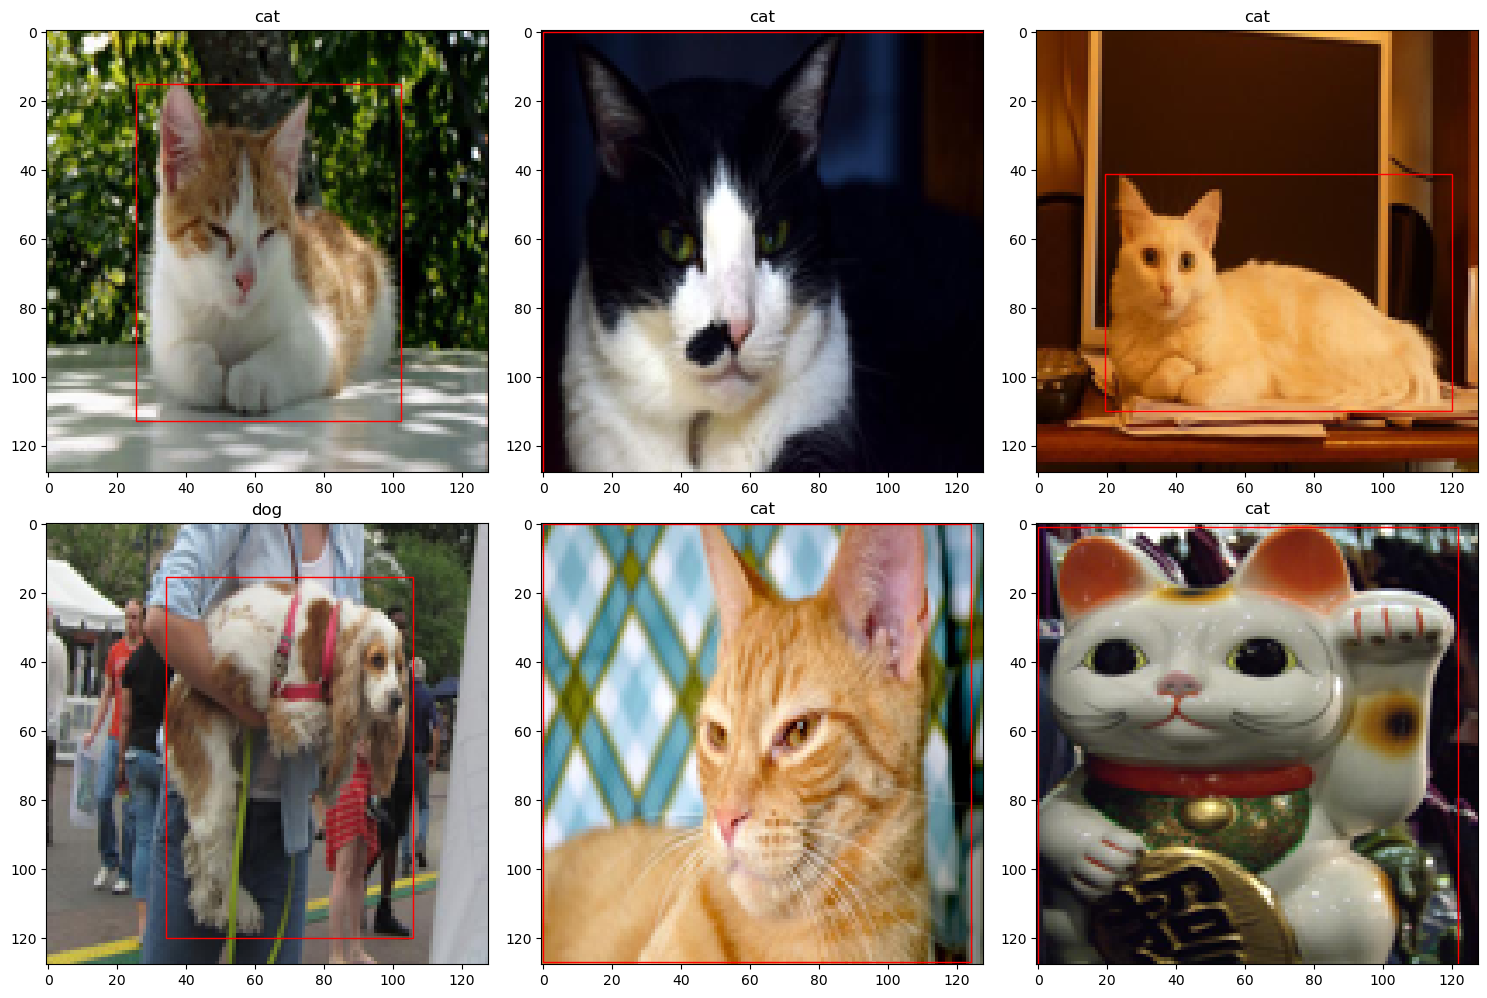

In [10]:
# Plot 6 random images to ensure that all data was properly loaded
fig, ax = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False, figsize = (15, 10))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(X.shape[0], size = 6, replace = False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128, 128, 3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2] - coords[0], coords[3] - coords[1], 
                                  edgecolor = 'red', facecolor = 'none'))

plt.tight_layout()
plt.show()

## Classification Baseline: Logistic Regression (subsample)

In [11]:
np.random.seed(42)

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y_label, test_size = 0.2, random_state = 42)

subsample_rate = 0.3

X_train_label_s, _, y_train_label_s, _ = train_test_split(X_train_label, y_train_label, stratify = y_train_label, train_size = subsample_rate, random_state = 42)
X_test_label_s, _, y_test_label_s, _ = train_test_split(X_test_label, y_test_label, stratify = y_test_label, train_size = subsample_rate, random_state = 42)

In [12]:
print('X_train_label:', X_train_label.shape)
print('X_test_label:', X_test_label.shape)
print('y_train_label:', y_train_label.shape)
print('y_test_label:', y_test_label.shape)
print('X_train_label_s:', X_train_label_s.shape)
print('X_test_label_s:', X_test_label_s.shape)
print('y_train_label_s:', y_train_label_s.shape)
print('y_test_label_s:', y_test_label_s.shape)

X_train_label: (10372, 49152)
X_test_label: (2594, 49152)
y_train_label: (10372,)
y_test_label: (2594,)
X_train_label_s: (3111, 49152)
X_test_label_s: (778, 49152)
y_train_label_s: (3111,)
y_test_label_s: (778,)


In [13]:
model_results_label = pd.DataFrame(columns = ['Model', 'Train Accuracy', 'Test Accuracy'])
model_results_label

Empty DataFrame
Columns: [Model, Train Accuracy, Test Accuracy]
Index: []

In [14]:
model = Pipeline([('scaler', MinMaxScaler()),
                  ('logreg', LogisticRegression(penalty = 'l2',
                                                solver = 'lbfgs',
                                                random_state = 42,
                                                max_iter = 15,
                                                n_jobs = -1,
                                                verbose = 5))], verbose = True)

model.fit(X_train_label_s, y_train_label_s)

model_results_label.loc[len(model_results_label.index)] = ['Logistic Regression Baseline',
                                                           accuracy_score(y_train_label_s, model.predict(X_train_label_s)),
                                                           accuracy_score(y_test_label_s, model.predict(X_test_label_s))]

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.7min finished


[Pipeline] ............ (step 2 of 2) Processing logreg, total= 3.7min


In [15]:
model_results_label

Model  Train Accuracy  Test Accuracy
0  Logistic Regression Baseline        0.657345        0.53856

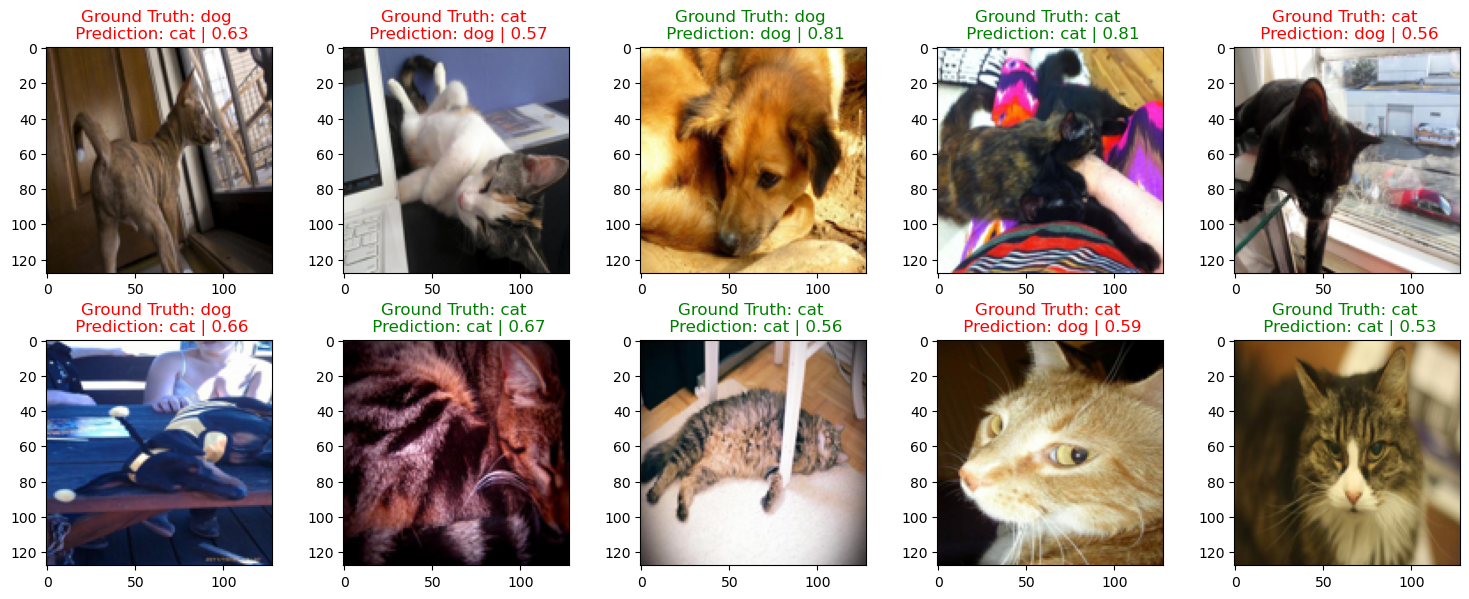

In [16]:
y_pred_label_s = model.predict(X_test_label_s)
y_pred_label_s_proba = model.predict_proba(X_test_label_s)

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = False, sharey = False, figsize = (15, 6))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(X_test_label_s.shape[0], size = 10, replace = False)):
#for i in range(10):
    img = X_test_label_s[j].reshape(128, 128, 3)
    ax[i].imshow(img)
    ax[i].set_title('Ground Truth: {0} \n Prediction: {1} | {2:.2f}'.format(idx_to_label[y_test_label_s[j]], 
                                                                            idx_to_label[y_pred_label_s[j]],
                                                                            y_pred_label_s_proba[j][y_pred_label_s[j]]), 
                    color = ('green' if y_pred_label_s[j] == y_test_label_s[j] else 'red'))

plt.tight_layout()
plt.show()

## Regression Baseline: Linear Regression (subsample)

In [17]:
np.random.seed(42)

X_train_bbox, X_test_bbox, y_train_bbox, y_test_bbox = train_test_split(X, y_bbox, test_size = 0.2, random_state = 42)

subsample_rate = 0.3

# Must stratify in the same way as with labels in order to merge the classification and regression results
X_train_bbox_s, _, y_train_bbox_s, _ = train_test_split(X_train_bbox, y_train_bbox, stratify = y_train_label, train_size = subsample_rate, random_state = 42)
X_test_bbox_s, _, y_test_bbox_s, _ = train_test_split(X_test_bbox, y_test_bbox, stratify = y_test_label, train_size = subsample_rate, random_state = 42)

In [18]:
print('X_train_bbox:', X_train_bbox.shape)
print('X_test_bbox:', X_test_bbox.shape)
print('y_train_bbox:', y_train_bbox.shape)
print('y_test_bbox:', y_test_bbox.shape)
print('X_train_bbox_s:', X_train_bbox_s.shape)
print('X_test_bbox_s:', X_test_bbox_s.shape)
print('y_train_bbox_s:', y_train_bbox_s.shape)
print('y_test_bbox_s:', y_test_bbox_s.shape)

X_train_bbox: (10372, 49152)
X_test_bbox: (2594, 49152)
y_train_bbox: (10372, 4)
y_test_bbox: (2594, 4)
X_train_bbox_s: (3111, 49152)
X_test_bbox_s: (778, 49152)
y_train_bbox_s: (3111, 4)
y_test_bbox_s: (778, 4)


In [19]:
model_results_bbox = pd.DataFrame(columns = ['Model', 'Train MSE', 'Test MSE'])
model_results_bbox

Empty DataFrame
Columns: [Model, Train MSE, Test MSE]
Index: []

In [20]:
model = Pipeline([('scaler', MinMaxScaler()),
                  ('linreg', LinearRegression(n_jobs = -1))], verbose = True)

model.fit(X_train_bbox_s, y_train_bbox_s)

model_results_bbox.loc[len(model_results_bbox.index)] = ['Linear Regression Baseline',
                                                         mean_squared_error(y_train_bbox_s, model.predict(X_train_bbox_s)),
                                                         mean_squared_error(y_test_bbox_s, model.predict(X_test_bbox_s))]

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.7s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  57.1s


In [21]:
model_results_bbox

Model     Train MSE  Test MSE
0  Linear Regression Baseline  1.055399e-29  0.022628

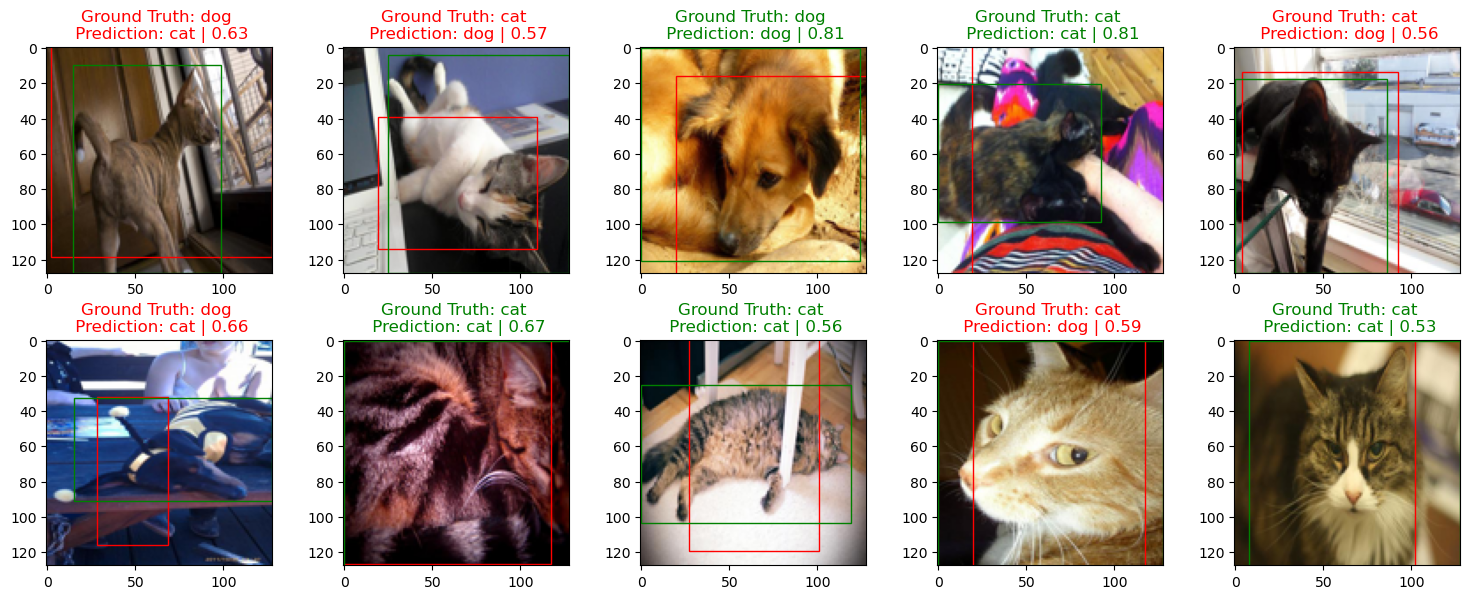

In [22]:
y_pred_bbox_s = model.predict(X_test_bbox_s)

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = False, sharey = False, figsize = (15, 6))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(X_test_bbox_s.shape[0], size = 10, replace = False)):
#for j in range(10):
    img = X_test_bbox_s[j].reshape(128, 128, 3)
    coords = y_pred_bbox_s[j] * 128
    coords_true = y_test_bbox_s[j] * 128
    ax[i].imshow(img)
    ax[i].set_title('Ground Truth: {0} \n Prediction: {1} | {2:.2f}'.format(idx_to_label[y_test_label_s[j]],
                                                                            idx_to_label[y_pred_label_s[j]],
                                                                            y_pred_label_s_proba[j][y_pred_label_s[j]]),
                    color = ('green' if y_pred_label_s[j] == y_test_label_s[j] else 'red'))
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]),
                                  coords[2] - coords[0], coords[3] - coords[1], 
                                  edgecolor = 'red', facecolor = 'none'))
    ax[i].add_patch(plt.Rectangle((coords_true[0], coords_true[1]),
                                  coords_true[2] - coords_true[0], coords_true[3] - coords_true[1], 
                                  edgecolor = 'green', facecolor = 'none'))

plt.tight_layout()
plt.show()